
# Regression Modeling - Movie Popularity (Improved)

This version is optimized to improve weak model performance by:
- comparing both **log-target** and **raw-target** model families,
- emphasizing robust tree boosting (`HistGradientBoostingRegressor`) on raw non-negative target,
- using strict time-aware CV and chronological holdout,
- keeping everything analysis-only (no artifact exports).


In [1]:

import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import ExtraTreesRegressor, HistGradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import ElasticNet, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")
np.random.seed(42)
RANDOM_STATE = 42



## Project-Rubric Alignment

- **Decision:** choose a model that improves forecast quality vs baseline for pre-release planning.
- **Primary metric:** RMSE on raw popularity.
- **Guardrails:** MAE, R2, sMAPE, and stability across time-based folds.
- **Method discipline:** chronological split + time-series CV to reflect real deployment.
- **Interpretability:** SHAP-based top drivers for presentation and business discussion.


## 1) Load engineered data

In [2]:

model_path = Path("data/data_model_with_target.csv")
if not model_path.exists():
    model_path = Path("../data/data_model_with_target.csv")

if not model_path.exists():
    raise FileNotFoundError("Could not find data_model_with_target.csv")

df = pd.read_csv(model_path)
print("Loaded:", model_path, df.shape)

if "popularity" not in df.columns:
    raise ValueError("Expected 'popularity' column")


Loaded: ../data/data_model_with_target.csv (9290, 90)


## 2) Feature/target setup and chronological split

In [3]:

X = df.drop(columns=["popularity"]).copy()
y_raw = df["popularity"].astype(float).copy()

if "release_year" not in X.columns:
    raise ValueError("release_year is required for time-aware split")

# Drop near-constant numeric features (usually pure noise)
var = X.var(numeric_only=True)
low_var_cols = var[var <= 1e-8].index.tolist()
if low_var_cols:
    X = X.drop(columns=low_var_cols)

# Sort by release_year for chronological validation
sort_idx = X["release_year"].sort_values(kind="mergesort").index
X_sorted = X.loc[sort_idx].reset_index(drop=True)
y_sorted_raw = y_raw.loc[sort_idx].reset_index(drop=True)
y_sorted_log = np.log1p(y_sorted_raw)

split_at = int(0.8 * len(X_sorted))
X_train = X_sorted.iloc[:split_at].copy()
X_test = X_sorted.iloc[split_at:].copy()

y_train_raw = y_sorted_raw.iloc[:split_at].copy()
y_test_raw = y_sorted_raw.iloc[split_at:].copy()
y_train_log = y_sorted_log.iloc[:split_at].copy()
y_test_log = y_sorted_log.iloc[split_at:].copy()

# Log-target cap only for robustness in log-family models
cap_log = y_train_log.quantile(0.995)
y_train_log_capped = y_train_log.clip(upper=cap_log)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train years:", int(X_train['release_year'].min()), "to", int(X_train['release_year'].max()))
print("Test years:", int(X_test['release_year'].min()), "to", int(X_test['release_year'].max()))
print("Dropped low-variance columns:", len(low_var_cols))


Train shape: (7432, 87) Test shape: (1858, 87)
Train years: 2010 to 2022
Test years: 2022 to 2025
Dropped low-variance columns: 2


## 3) Model library (raw-target + log-target)

In [4]:

num_cols = X_train.columns.tolist()

linear_preprocess = ColumnTransformer(
    [("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]), num_cols)],
    remainder="drop",
)

tree_preprocess = ColumnTransformer(
    [("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
    ]), num_cols)],
    remainder="drop",
)

# target_mode in {"raw", "log"}
model_specs = {
    "baseline_raw": {
        "pipe": Pipeline([("preprocess", tree_preprocess), ("model", DummyRegressor(strategy="median"))]),
        "target_mode": "raw",
    },
    "ridge_log": {
        "pipe": Pipeline([("preprocess", linear_preprocess), ("model", Ridge(alpha=2.5, random_state=RANDOM_STATE))]),
        "target_mode": "log",
    },
    "elastic_log": {
        "pipe": Pipeline([("preprocess", linear_preprocess), ("model", ElasticNet(alpha=0.0008, l1_ratio=0.3, max_iter=12000, random_state=RANDOM_STATE))]),
        "target_mode": "log",
    },
    "extra_log": {
        "pipe": Pipeline([("preprocess", tree_preprocess), ("model", ExtraTreesRegressor(
            n_estimators=380,
            max_depth=None,
            min_samples_leaf=1,
            max_features=0.8,
            random_state=RANDOM_STATE,
            n_jobs=1,
        ))]),
        "target_mode": "log",
    },
    "hgb_squared_raw": {
        "pipe": Pipeline([("preprocess", tree_preprocess), ("model", HistGradientBoostingRegressor(
            loss="squared_error",
            max_iter=500,
            learning_rate=0.03,
            max_depth=6,
            min_samples_leaf=20,
            l2_regularization=0.3,
            random_state=RANDOM_STATE,
        ))]),
        "target_mode": "raw",
    },
    "hgb_poisson_raw": {
        "pipe": Pipeline([("preprocess", tree_preprocess), ("model", HistGradientBoostingRegressor(
            loss="poisson",
            max_iter=500,
            learning_rate=0.03,
            max_depth=6,
            min_samples_leaf=20,
            l2_regularization=0.3,
            random_state=RANDOM_STATE,
        ))]),
        "target_mode": "raw",
    },
}

print("Models:", list(model_specs.keys()))


Models: ['baseline_raw', 'ridge_log', 'elastic_log', 'extra_log', 'hgb_squared_raw', 'hgb_poisson_raw']


## 4) Time-aware CV with multiple metrics

In [5]:

def smape(y_true, y_pred):
    denom = np.abs(y_true) + np.abs(y_pred)
    denom = np.where(denom == 0, 1e-9, denom)
    return float(np.mean(2 * np.abs(y_pred - y_true) / denom) * 100)


def metric_row(y_true_raw, y_pred_raw):
    return {
        "rmse": float(np.sqrt(mean_squared_error(y_true_raw, y_pred_raw))),
        "mae": float(mean_absolute_error(y_true_raw, y_pred_raw)),
        "r2": float(r2_score(y_true_raw, y_pred_raw)),
        "smape": smape(y_true_raw, y_pred_raw),
    }


def fit_predict_by_mode(pipe, target_mode, Xtr, ytr_raw, ytr_log, Xva):
    m = clone(pipe)
    if target_mode == "raw":
        m.fit(Xtr, ytr_raw)
        pred = m.predict(Xva)
        pred_raw = np.maximum(pred, 0)
    elif target_mode == "log":
        m.fit(Xtr, ytr_log)
        pred = m.predict(Xva)
        pred_raw = np.maximum(np.expm1(pred), 0)
    else:
        raise ValueError(f"Unknown target_mode: {target_mode}")
    return m, pred_raw


def evaluate_tscv(model_name, spec, X_data, y_raw_data, y_log_data, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    fold_rows = []

    for fold, (idx_tr, idx_va) in enumerate(tscv.split(X_data), start=1):
        Xtr = X_data.iloc[idx_tr]
        Xva = X_data.iloc[idx_va]

        ytr_raw = y_raw_data.iloc[idx_tr]
        yva_raw = y_raw_data.iloc[idx_va]

        ytr_log = y_log_data.iloc[idx_tr]

        _, pred_raw = fit_predict_by_mode(
            spec["pipe"],
            spec["target_mode"],
            Xtr,
            ytr_raw,
            ytr_log,
            Xva,
        )

        row = metric_row(yva_raw, pred_raw)
        row.update({"model": model_name, "fold": fold})
        fold_rows.append(row)

    return pd.DataFrame(fold_rows)

cv_folds = []
for name, spec in model_specs.items():
    cv_folds.append(evaluate_tscv(name, spec, X_train, y_train_raw, y_train_log_capped, n_splits=5))

cv_fold_df = pd.concat(cv_folds, ignore_index=True)
cv_summary = (
    cv_fold_df.groupby("model", as_index=False)
    .agg(
        cv_rmse_mean=("rmse", "mean"),
        cv_rmse_std=("rmse", "std"),
        cv_mae_mean=("mae", "mean"),
        cv_r2_mean=("r2", "mean"),
        cv_smape_mean=("smape", "mean"),
    )
    .sort_values("cv_rmse_mean")
    .reset_index(drop=True)
)

cv_summary


,model,cv_rmse_mean,cv_rmse_std,cv_mae_mean,cv_r2_mean,cv_smape_mean
0,elastic_log,2.244096,0.604488,1.228273,0.187866,20.959414
1,ridge_log,2.253694,0.623580,1.230605,0.178783,20.993850
2,extra_log,2.359904,0.506429,1.702204,0.114261,28.894794
3,hgb_poisson_raw,2.485527,0.711284,1.917514,-0.012369,32.128812
4,hgb_squared_raw,2.633882,0.865734,2.119574,-0.155092,34.951903
5,baseline_raw,2.665483,0.180878,1.293340,-0.094975,21.859268


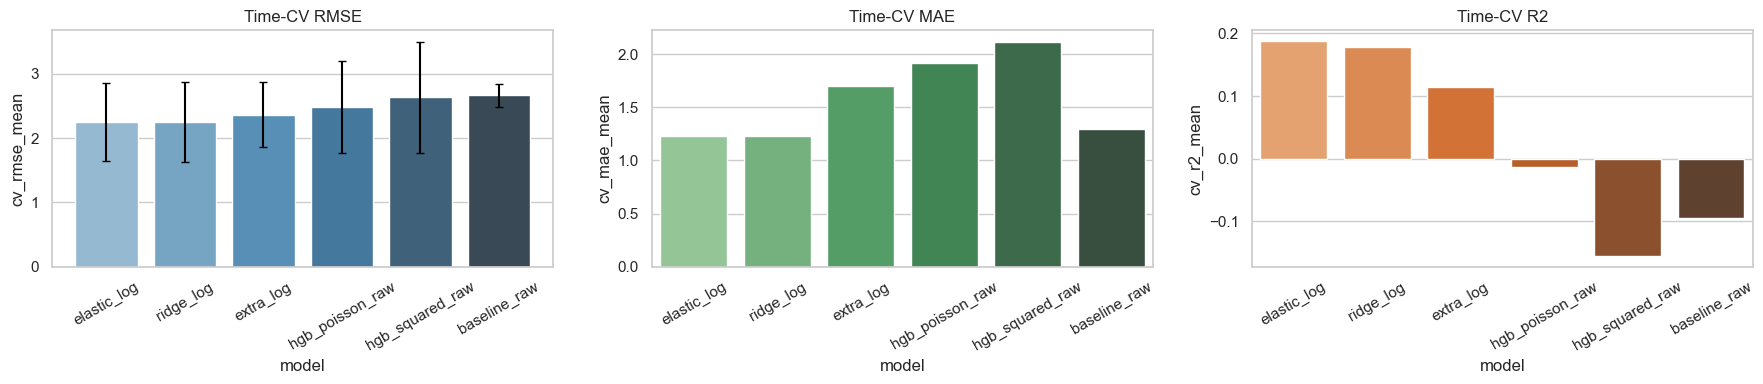

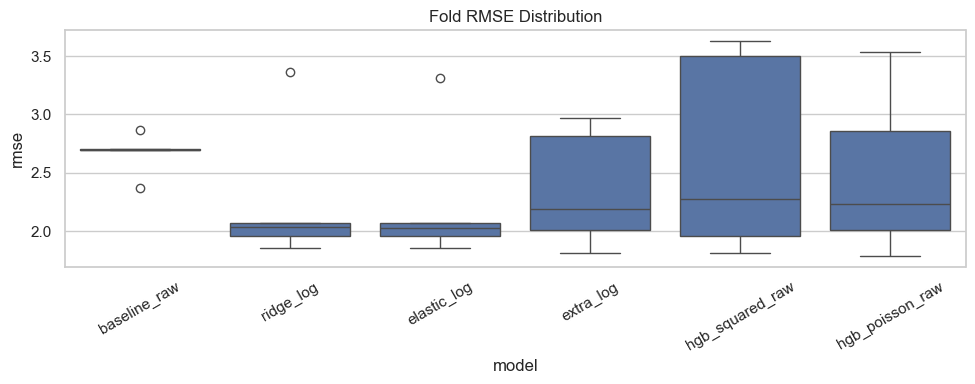

In [6]:

fig, axes = plt.subplots(1, 3, figsize=(18, 4))

sns.barplot(data=cv_summary, x="model", y="cv_rmse_mean", ax=axes[0], palette="Blues_d")
axes[0].errorbar(
    np.arange(len(cv_summary)),
    cv_summary["cv_rmse_mean"],
    yerr=cv_summary["cv_rmse_std"].fillna(0),
    fmt="none", ecolor="black", capsize=3,
)
axes[0].set_title("Time-CV RMSE")
axes[0].tick_params(axis="x", rotation=30)

sns.barplot(data=cv_summary, x="model", y="cv_mae_mean", ax=axes[1], palette="Greens_d")
axes[1].set_title("Time-CV MAE")
axes[1].tick_params(axis="x", rotation=30)

sns.barplot(data=cv_summary, x="model", y="cv_r2_mean", ax=axes[2], palette="Oranges_d")
axes[2].set_title("Time-CV R2")
axes[2].tick_params(axis="x", rotation=30)

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
sns.boxplot(data=cv_fold_df, x="model", y="rmse")
plt.title("Fold RMSE Distribution")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


## 5) Holdout comparison

In [7]:

holdout_rows = []
holdout_preds = {}
fitted_models = {}

for name, spec in model_specs.items():
    fitted, pred_raw = fit_predict_by_mode(
        spec["pipe"],
        spec["target_mode"],
        X_train,
        y_train_raw,
        y_train_log_capped,
        X_test,
    )

    row = metric_row(y_test_raw, pred_raw)
    row["model"] = name
    holdout_rows.append(row)

    holdout_preds[name] = pred_raw
    fitted_models[name] = fitted

holdout_results = pd.DataFrame(holdout_rows).sort_values("rmse").reset_index(drop=True)
holdout_results


,rmse,mae,r2,smape,model
0,15.863790,3.748852,0.031499,28.109396,hgb_poisson_raw
1,15.899698,3.744983,0.027109,28.067313,hgb_squared_raw
2,16.031009,3.799656,0.010973,28.447119,extra_log
3,16.083092,3.794058,0.004537,28.015153,ridge_log
4,16.088086,3.796610,0.003918,28.034541,elastic_log
5,16.619241,4.297335,-0.062940,35.170273,baseline_raw


In [8]:

# Small ensemble of top 3 holdout models
top3 = holdout_results.head(3)["model"].tolist()
blend_pred = np.mean([holdout_preds[m] for m in top3], axis=0)
blend_metrics = metric_row(y_test_raw, blend_pred)
blend_metrics["model"] = "blend_top3_equal"

holdout_plus_blend = pd.concat([
    holdout_results,
    pd.DataFrame([blend_metrics])
], ignore_index=True).sort_values("rmse").reset_index(drop=True)

holdout_plus_blend


,rmse,mae,r2,smape,model
0,15.863790,3.748852,0.031499,28.109396,hgb_poisson_raw
1,15.899698,3.744983,0.027109,28.067313,hgb_squared_raw
2,15.922851,3.739720,0.024274,27.894651,blend_top3_equal
3,16.031009,3.799656,0.010973,28.447119,extra_log
4,16.083092,3.794058,0.004537,28.015153,ridge_log
5,16.088086,3.796610,0.003918,28.034541,elastic_log
6,16.619241,4.297335,-0.062940,35.170273,baseline_raw


In [9]:

best_name = holdout_plus_blend.iloc[0]["model"]
print("Best holdout model:", best_name)

if best_name == "blend_top3_equal":
    best_pred_raw = blend_pred
    base_name = holdout_results.iloc[0]["model"]
    explain_model = fitted_models[base_name]
    print("Using SHAP on best single model for interpretability:", base_name)
else:
    best_pred_raw = holdout_preds[best_name]
    explain_model = fitted_models[best_name]

print("Best metrics:")
print(holdout_plus_blend.iloc[0][["rmse", "mae", "r2", "smape"]])


Best holdout model: hgb_poisson_raw
Best metrics:
rmse      15.86379
mae       3.748852
r2        0.031499
smape    28.109396
Name: 0, dtype: object


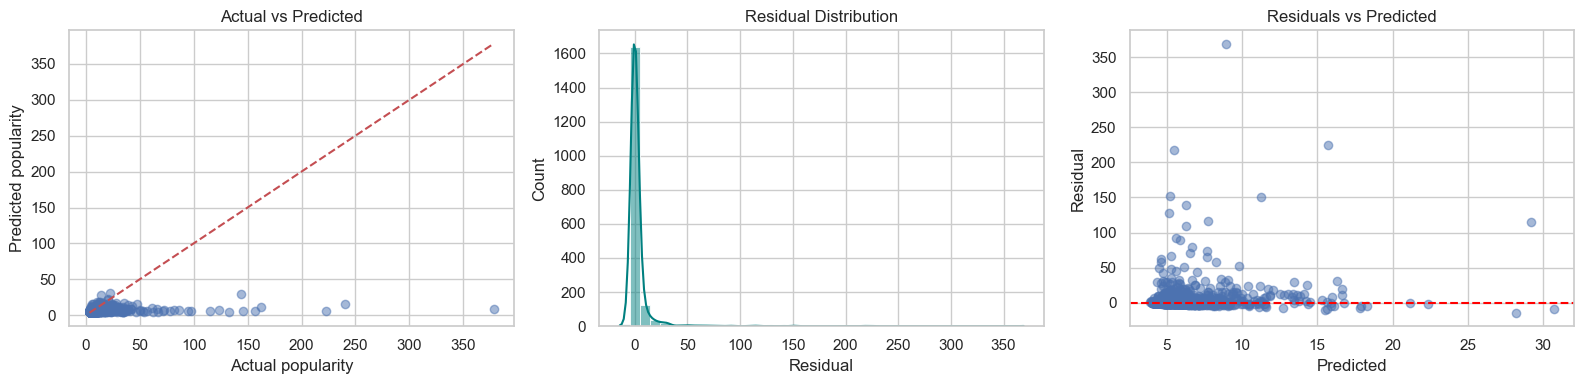

In [10]:

residuals = y_test_raw - best_pred_raw

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

axes[0].scatter(y_test_raw, best_pred_raw, alpha=0.5)
mn = float(min(y_test_raw.min(), best_pred_raw.min()))
mx = float(max(y_test_raw.max(), best_pred_raw.max()))
axes[0].plot([mn, mx], [mn, mx], "r--")
axes[0].set_title("Actual vs Predicted")
axes[0].set_xlabel("Actual popularity")
axes[0].set_ylabel("Predicted popularity")

sns.histplot(residuals, bins=40, kde=True, ax=axes[1], color="teal")
axes[1].set_title("Residual Distribution")
axes[1].set_xlabel("Residual")

axes[2].scatter(best_pred_raw, residuals, alpha=0.5)
axes[2].axhline(0, color="red", linestyle="--")
axes[2].set_title("Residuals vs Predicted")
axes[2].set_xlabel("Predicted")
axes[2].set_ylabel("Residual")

plt.tight_layout()
plt.show()


## 6) SHAP interpretation (bounded for runtime stability)

In [11]:

X_proc_train = explain_model.named_steps["preprocess"].transform(X_train)
X_proc_test = explain_model.named_steps["preprocess"].transform(X_test)
feature_names = explain_model.named_steps["preprocess"].get_feature_names_out().tolist()
estimator = explain_model.named_steps["model"]

X_bg = X_proc_train[: min(160, X_proc_train.shape[0])]
X_sample = X_proc_test[: min(120, X_proc_test.shape[0])]

shap_mode = ""
shap_values_arr = None

try:
    explainer = shap.TreeExplainer(estimator)
    vals = explainer.shap_values(X_sample, check_additivity=False)
    shap_values_arr = vals[1] if isinstance(vals, list) else vals
    shap_mode = "tree"
except Exception:
    try:
        explainer = shap.LinearExplainer(estimator, X_bg)
        shap_values_arr = explainer.shap_values(X_sample)
        shap_mode = "linear"
    except Exception:
        explainer = shap.KernelExplainer(estimator.predict, X_bg[:40])
        shap_values_arr = explainer.shap_values(X_sample[:30], nsamples=80)
        shap_mode = "kernel"

arr = np.asarray(shap_values_arr)
if arr.ndim == 1:
    arr = arr.reshape(1, -1)

shap_importance = (
    pd.DataFrame({
        "feature": feature_names,
        "mean_abs_shap": np.abs(arr).mean(axis=0),
    })
    .sort_values("mean_abs_shap", ascending=False)
    .reset_index(drop=True)
)

print("SHAP mode:", shap_mode)
shap_importance.head(20)


SHAP mode: tree


,feature,mean_abs_shap
0,num__release_year,0.081039
1,num__keyword_count,0.051816
2,num__log_budget,0.051164
3,num__top2_cast_pop_sum,0.018201
4,num__runtime,0.017773
5,num__director_popularity,0.013690
6,num__actor2_popularity,0.011944
7,num__actor1_popularity,0.010543
8,num__actor3_popularity,0.009726
9,num__actor4_popularity,0.008777


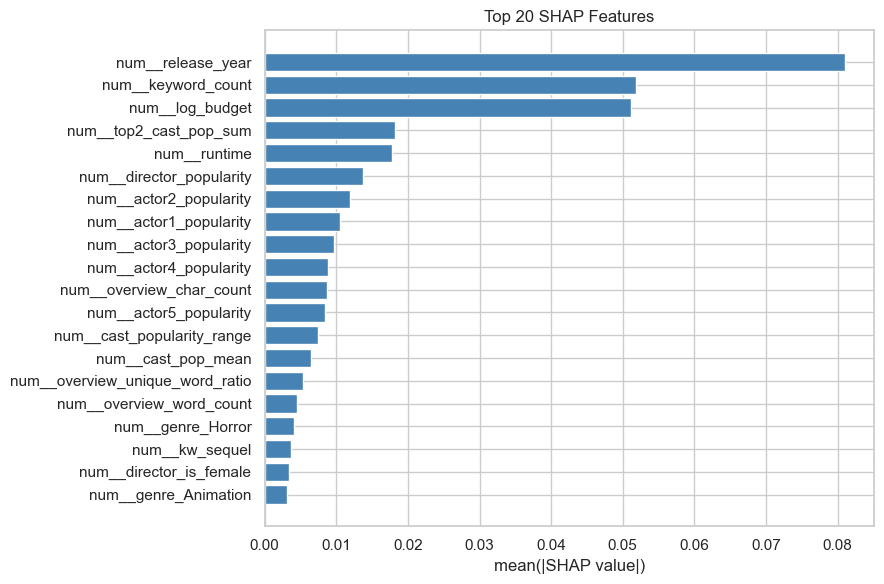

In [12]:

plt.figure(figsize=(9, 6))
plot_df = shap_importance.head(20).sort_values("mean_abs_shap", ascending=True)
plt.barh(plot_df["feature"], plot_df["mean_abs_shap"], color="steelblue")
plt.title("Top 20 SHAP Features")
plt.xlabel("mean(|SHAP value|)")
plt.tight_layout()
plt.show()



## Limitations and Next Improvements

- Popularity is noisy and partially influenced by external market events not included here.
- Future improvements: richer text embeddings, marketing/social trend signals, and segmented models by genre/language.
- Team workflow recommendation: track experiments in GitHub issues/board and lock evaluation protocol before tuning.
